# Optimizing the width of a Pulse to maximize the fidelity of an X-gate

In this notebook, the goal is to build a script that optimizes the fidelity of an X-gate following Qiskit Dynamics tutorials.


In [1]:
# Import all necessary libraries

import qiskit_dynamics
import qiskit_dynamics.pulse as qdpulse
import qiskit.pulse as pulse
import numpy as np
import matplotlib.pyplot as plt

from qiskit.quantum_info.operators import Operator
from scipy.optimize import minimize


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Creating a pulse

The first step is to initialize the pulse using qiskit.pulse. This code is done as a function so that it can be modified to take the type of pulse as an input. At this moment, it only uses GaussianSquare.

In [2]:

def define_pulse(duration, amp, sigma, width):

    # Schedule a pulse
    with pulse.build(name="Generated pulse") as thePulse: # creates a pulse schedule object with the name thePulse
        pulse.play(pulse.GaussianSquare(duration=duration, amp=amp, sigma=sigma, width=width), pulse.DriveChannel(0)) # plays the GaussianSquare pulse for qubit 0
    
    #thePulse.draw() # draw the pulse

    return thePulse

## Optimization

The rest of the steps for the task have been compiled into a single function, so that in the future
it can be modified to perform the optimization of the width of a pulse to different pulse shapes, optimization methods, etc. 

Currently the only pulse shape possible is GaussianSquare, the optimization method can be specified as an input.



The pulse needs to be first initialized before it can be used for the maximization of the fidelity of the gate.
The steps taken by the function are as below:

1. Convert the pulse into a signal using the qiskit_dynamics.pulse function InstructionToSignals. 
2. Set up a solver for the system Hamiltonian.
3. Simulate the pulse schedule using the model created in step 2.
4. Define a gate fidelity function
5. Define an objective function for optimization
6. Optimize the objective function


The model qubit has Hamiltonian:

$$
H(t) = 2\pi\omega\frac{Z}{2} + 2\pi rs(t)\frac{X}{2},
$$

where $\omega$ is the qubit frequency, r the driver strength, $s(t)$ the drive signal that will be optimized, and $X$ and $Z$ the Pauli X and Z operators.

The solver implemented at step 2. will follow the Hamiltonian above, 

In [ ]:

def optimize(duration, amp, sigma, initial_guess, method):

    r = 0.02         # Strength of the Rabi-rate (GHz)
    w = 5.0          # Transition frequency of the qubit (GHz)
    dt = 0.22        # Sample duration (ns)


    # Step 1. Create a converter to convert pulse to a signal:
    converter = qdpulse.InstructionToSignals(dt, carriers={"d0": w})


    # Step 2. Defining a solver:

    # Operators
    X = Operator.from_label('X') # The X operator
    Z = Operator.from_label('Z') # The Z operator

    static_hamiltonian = 2 * np.pi * w * Z / 2
    operators = [2 * np.pi * r * X / 2]

    # Solver for simulating pulse schedules based on the Hamiltonian 
    hamiltonian_solver = qiskit_dynamics.Solver(static_hamiltonian=static_hamiltonian, hamiltonian_operators=operators, rotating_frame=static_hamiltonian, 
        rwa_cutoff_freq=2*w, hamiltonian_channels=['d0'], channel_carrier_freqs={'d0': w}, dt=dt)


    # Step 4. Definition for gate fidelity function:
    # The purpose of the task is to maximize the fidelity of the X-gate:
    X_op = X.data
    # A function calculating the fidelity:
    def fidelity(U):
        return np.abs(np.trace(np.conjugate(X_op).T @ U))**2 / 4.0 #np.abs(np.sum(X_op * U))**2 / 4.0


    # Step 5. 
    # Defining the function that is minimized based on the width of the pulse in order to maximize X-gate fidelity
    def objective(width_arr):

        width = width_arr[0] # The width of a pulse

        scheduled = define_pulse(duration, amp, sigma, width)    # Define a pulse with the specified width
        signal = converter.get_signals(scheduled)                # Convert


        # Step 3. Simulating the pulse schedule
        result = hamiltonian_solver.solve(y0=np.eye(2, dtype=complex), method='jax_odeint', t_span=[0, duration * dt], signals=[signal], atol=1e-8, rtol=1e-8)
        
        U = result[0].y[-1]
        fid = fidelity(U) # The fidelity

        return 1 - fid # Goal to minimize the infidelity
    
    # Step 6.Optimization: the minimizer tries to minimize the objective function using 
    # the specified method and an initial width value
    optimized_result = minimize(fun=objective, x0=np.array([initial_guess]), method=method)
    optimized_width = optimized_result.x[0] 

    print(optimized_result.message)
    print(f"The optimized width is {optimized_width}")
    print('Number of function evaluations: ' + str(optimized_result.nfev))
    print('Function value: ' + str(optimized_result.fun)) # Value of fidelity with the optimized pulse width

    return optimized_result, optimized_width
    


## Running the script

Specified variables for the Gaussian Square pulse in the optimization task. The initial width and other
variables can be adjusted. The current values have been chosen by trial and error as well as the given tutorials.

To run the optimize function, include the method of optimization as the last parameter.

In [ ]:

# Defining the parameters for the envelope of the Gaussian Square
amp = 1.0 / 1.75          # Amplitude of envelope
sigma = 200               # Gaussian edge width 
duration = 500            # Number of time-steps (full time divided with the sample times)

initial_width = 25

# Optimizing the pulse width to maximize fidelity
optimized_result, optimized_width = optimize(duration, amp, sigma, initial_width,'BFGS')

print('Fidelity: ' + str(1 - optimized_result.fun))


Optimization terminated successfully.
The optimized width is 25.0
Number of function evaluations: 2
Function value: 0.09090692
Fidelity: 0.9090931


## Comparing the results of optimization to initial values

### Initial pulse

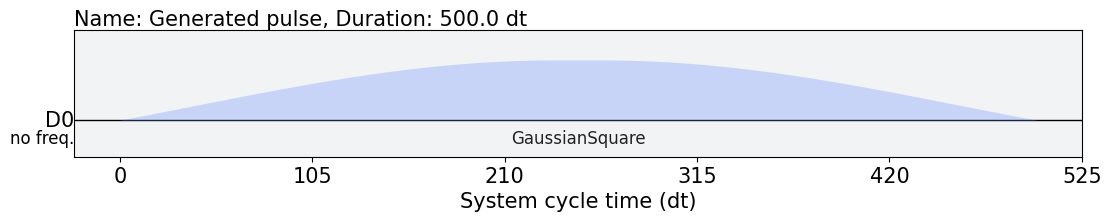

In [5]:
# Drawing the initial pulse
initial_pulse = define_pulse(duration, amp, sigma, initial_width)
initial_pulse.draw()

### BFGS optimization method

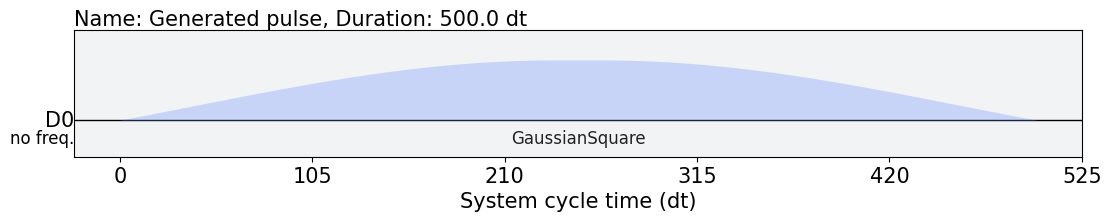

In [6]:

# The optimized pulse
optimized_pulse = define_pulse(duration, amp, sigma, optimized_width)
optimized_pulse.draw()


### Nelder-Mead optimization method 

Recreating the same optimization using the Nelder-Mead method as a parameter instead of the BFGS

Optimization terminated successfully.
The optimized width is 206.2891387939453
Number of function evaluations: 65
Function value: -1.430511474609375e-06
Fidelity: 1.0000014305114746


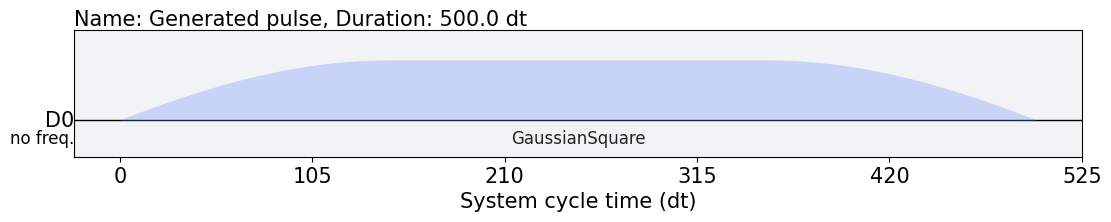

In [7]:

# Envelope for Gaussian Square
amp = 1.0 / 1.75       # Amplitude of envelope
sigma = 200            # Gaussian edge width 
duration = 500         # Number of time-steps (full time divided with the sample times)

initial_width = 25

# Optimizing the pulse width to maximize fidelity
optimized_result_NM, optimized_width_NM = optimize(duration, amp, sigma, initial_width,'Nelder-Mead')

print('Fidelity: ' + str(1 - optimized_result_NM.fun))

# The optimized pulse
optimized_pulse_NM = define_pulse(duration, amp, sigma, optimized_width_NM)
optimized_pulse_NM.draw()


### Comparing the pulse envelopes and signals for the two methods

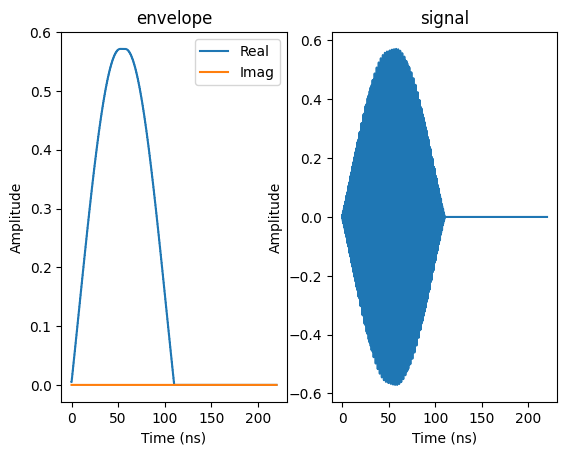

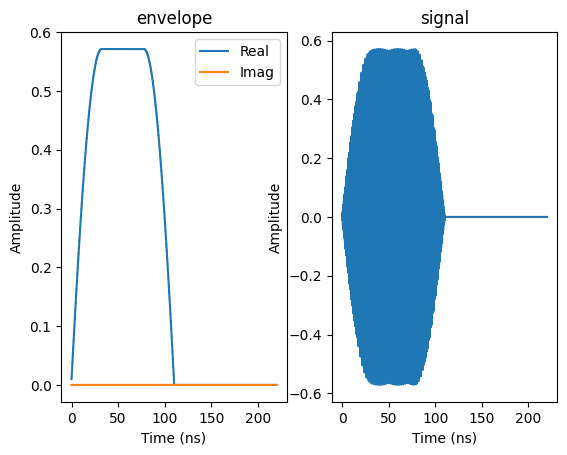

In [8]:
w = 5.0          # Transition frequency of the qubit (GHz)
dt = 0.22        # Sample duration (ns)
T = duration*dt

convert = qdpulse.InstructionToSignals(dt, carriers={"d0": w}) # converts a pulse to a signal

# Convert both BFGS and Nelder-Mead pulses to signals
signals = convert.get_signals(optimized_pulse)
signals_NM = convert.get_signals(optimized_pulse_NM) 

fig, axs = plt.subplots(1,2)
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0,2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)


fig, axs = plt.subplots(1,2)
for ax, title in zip(axs, ["envelope", "signal"]):
    signals_NM[0].draw(0,2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
